<a href="https://colab.research.google.com/github/iHev10/Object-Localization-from-scratch/blob/main/Object_Localization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import resize

import cv2

import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Identify actual boxes

In [ ]:
def data_generator(batch_size=64):
  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, 100, 100, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # make random boxes and store their locations
        row_0 = np.random.randint(0, 90)
        col_0 = np.random.randint(0, 90)
        row_1 = np.random.randint(row_0, 100)
        col_1 = np.random.randint(col_0, 100)

        x[n, row_0:row_1, col_0:col_1, :] = 1

        # normalize the cordinates
        y[n, 0] = row_0 / 100. # top row
        y[n, 1] = col_0 / 100. # left col
        y[n, 2] = (row_1 - row_0) / 100. # height
        y[n, 3] = (col_1 - col_0) / 100. # width

      yield x, y

In [ ]:
# create the model
vgg = VGG16(input_shape=(100, 100, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model.fit(data_generator(), steps_per_epoch=50, epochs=10)

Epoch 1/10
50/50 [==============================] - 14s 192ms/step - loss: 0.6056
Epoch 2/10
50/50 [==============================] - 10s 196ms/step - loss: 0.5165
Epoch 3/10
50/50 [==============================] - 10s 190ms/step - loss: 0.5098
Epoch 4/10
50/50 [==============================] - 10s 192ms/step - loss: 0.5063
Epoch 5/10
50/50 [==============================] - 9s 184ms/step - loss: 0.5057
Epoch 6/10
50/50 [==============================] - 9s 183ms/step - loss: 0.5074
Epoch 7/10
50/50 [==============================] - 9s 184ms/step - loss: 0.5051
Epoch 8/10
50/50 [==============================] - 9s 188ms/step - loss: 0.5036
Epoch 9/10
50/50 [==============================] - 9s 186ms/step - loss: 0.5046
Epoch 10/10
50/50 [==============================] - 9s 186ms/step - loss: 0.5022


In [ ]:
def plot_predictions():
  # generate a random image
  img = np.zeros((100, 100, 3))
  row_0 = np.random.randint(0, 90)
  col_0 = np.random.randint(0, 90)
  row_1 = np.random.randint(row_0, 100)
  col_1 = np.random.randint(col_0, 100)

  img[row_0:row_1, col_0:col_1, :] = 1

  # make predictions
  x = np.expand_dims(img, 0)
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * 100)
  y_0 = int(y_0 * 100)
  h = int(h * 100)
  w = int(w * 100)

  print(x_0, y_0, h, w)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_0 + w, x_0 + h), color=(255, 0, 0))
  plt.imshow(img)
  plt.title("predicted boxes")


1/1 [==============================] - 0s 19ms/step


27 66 62 15


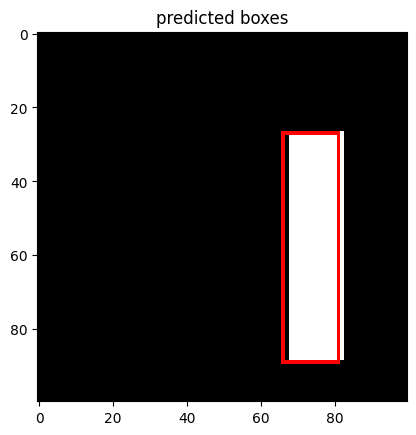

In [ ]:
plot_predictions()

# Locate an actual object

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-08 19:45:12--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-08 19:45:13 (63.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



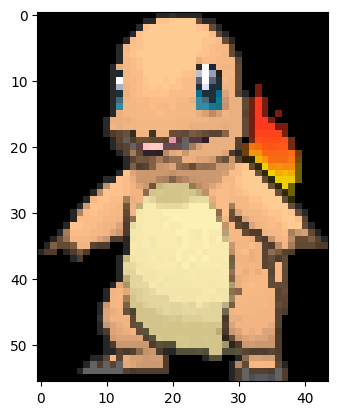

In [ ]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [ ]:
H, W = 300, 300 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - CH_H)
        col_0 = np.random.randint(0, W - CH_W)
        row_1 = row_0 + CH_H
        col_1 = col_0 + CH_W

        x[n, row_0:row_1, col_0:col_1, :] = object[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = CH_H / H # height
        y[n, 3] = CH_W / W # width

      yield x, y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model.fit(data_generator(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 78s 1s/step - loss: 0.8463
Epoch 2/5
50/50 [==============================] - 74s 1s/step - loss: 0.4987
Epoch 3/5
50/50 [==============================] - 74s 1s/step - loss: 0.4971
Epoch 4/5
50/50 [==============================] - 74s 1s/step - loss: 0.4971
Epoch 5/5
50/50 [==============================] - 74s 1s/step - loss: 0.4979


In [ ]:
def plot_predictions(object=object_img):
  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - CH_H)
  col_0 = np.random.randint(0, W - CH_W)
  row_1 = row_0 + CH_H
  col_1 = col_0 + CH_W

  img[row_0:row_1, col_0:col_1, :] = object[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0)
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 26ms/step
true location:  72 129 128 173
preds:  71 129 127 172


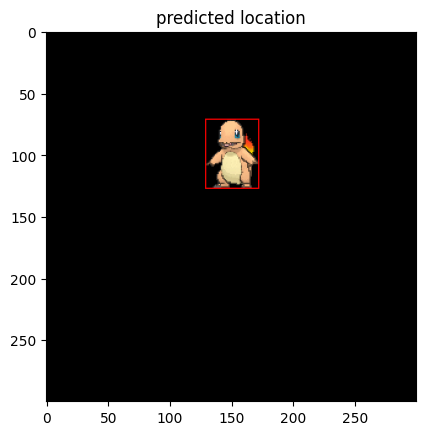

In [ ]:
plot_predictions()

# Different size objects

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-09 10:11:23--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-09 10:11:24 (75.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



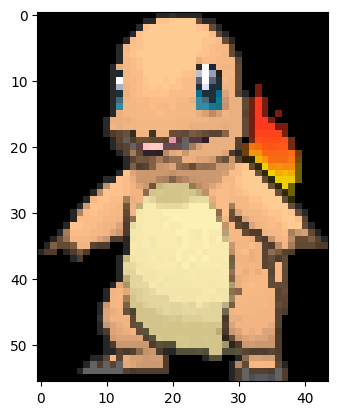

In [ ]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [ ]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator_with_resize(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # randomly select scale factore
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        # calculate new height and width
        new_h, new_w = int(scale * CH_H), int(scale * CH_W)
        # resize object
        resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - new_h)
        col_0 = np.random.randint(0, W - new_w)
        row_1 = row_0 + new_h
        col_1 = col_0 + new_w

        x[n, row_0:row_1, col_0:col_1, :] = resized_object[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = (row_1 - row_0) / H # height
        y[n, 3] = (col_1 - col_0) / W # width

      yield x/255., y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model.fit(data_generator_with_resize(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 63s 588ms/step - loss: 0.9546
Epoch 2/5
50/50 [==============================] - 30s 595ms/step - loss: 0.5507
Epoch 3/5
50/50 [==============================] - 30s 606ms/step - loss: 0.5473
Epoch 4/5
50/50 [==============================] - 31s 614ms/step - loss: 0.5454
Epoch 5/5
50/50 [==============================] - 31s 619ms/step - loss: 0.5445


In [ ]:
def plot_predictions_with_resize(object=object_img):
  # randomly select scale factore
  scale = 0.5 + np.random.random() # [0.5, 1.5]
  # calculate new height and width
  new_h, new_w = int(scale * CH_H), int(scale * CH_W)
  # resize object
  resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - new_h)
  col_0 = np.random.randint(0, W - new_w)
  row_1 = row_0 + new_h
  col_1 = col_0 + new_w

  img[row_0:row_1, col_0:col_1, :] = resized_object[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0) / 255.
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 20ms/step
true location:  111 73 153 106
preds:  112 73 152 105


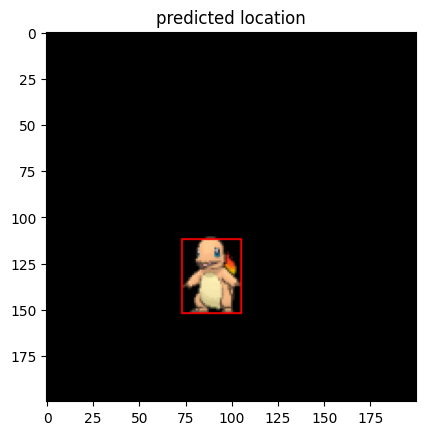

In [ ]:
plot_predictions_with_resize()

# Flipped objects

In [2]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-09 17:55:25--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-09 17:55:25 (65.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



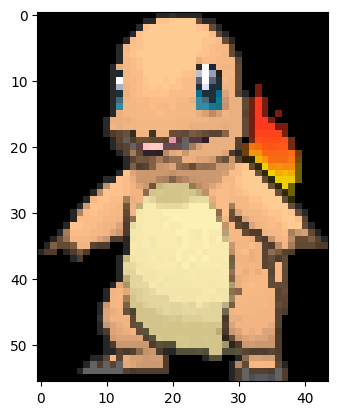

In [3]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [4]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator_flipped(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # randomly select scale factore
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        # calculate new height and width
        new_h, new_w = int(scale * CH_H), int(scale * CH_W)
        # resize object
        resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - new_h)
        col_0 = np.random.randint(0, W - new_w)
        row_1 = row_0 + new_h
        col_1 = col_0 + new_w

        # flip object
        if np.random.random() < 0.5:
          obj = np.fliplr(resized_object)
        else:
          obj = resized_object

        x[n, row_0:row_1, col_0:col_1, :] = obj[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = (row_1 - row_0) / H # height
        y[n, 3] = (col_1 - col_0) / W # width

      yield x/255., y

In [5]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001))

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
model.fit(data_generator_flipped(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 68s 662ms/step - loss: 0.5523
Epoch 2/5
50/50 [==============================] - 33s 650ms/step - loss: 0.5448
Epoch 3/5
50/50 [==============================] - 33s 654ms/step - loss: 0.5445
Epoch 4/5
50/50 [==============================] - 33s 655ms/step - loss: 0.5458
Epoch 5/5
50/50 [==============================] - 33s 651ms/step - loss: 0.5423


In [7]:
def plot_predictions_flipped(object=object_img):
  # randomly select scale factore
  scale = 0.5 + np.random.random() # [0.5, 1.5]
  # calculate new height and width
  new_h, new_w = int(scale * CH_H), int(scale * CH_W)
  # resize object
  resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - new_h)
  col_0 = np.random.randint(0, W - new_w)
  row_1 = row_0 + new_h
  col_1 = col_0 + new_w

  # flip object
  if np.random.random() < 0.5:
    obj = np.fliplr(resized_object)
  else:
    obj = resized_object

  img[row_0:row_1, col_0:col_1, :] = obj[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0) / 255.
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 19ms/step
true location:  32 46 79 83
preds:  33 46 78 83


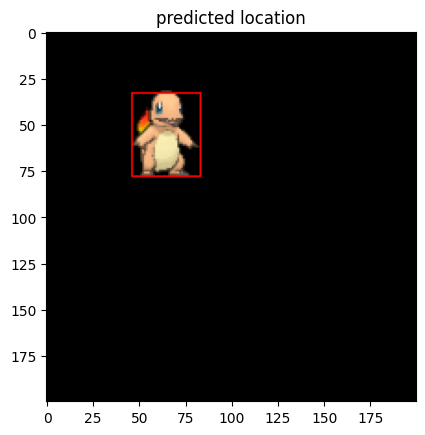

In [12]:
plot_predictions_flipped()